<a href="https://colab.research.google.com/github/asmital/Capsule-Networks/blob/master/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compatibility

The following 2 cells work for Jupyter notebook environments.

In [4]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 4.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
#Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!nvidia-smi

Sun Jun 21 18:01:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [8]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

Using TensorFlow backend.


2.2.4
1.15.2


In [9]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import keras.backend as K
from keras import callbacks
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.utils.data_utils import get_file
from keras import initializers, layers, models
from tensorflow.keras import backend

import matplotlib.pyplot as plt


import warnings 
warnings.filterwarnings('ignore')

# Layers in CapsNet

**Define the key layers required to build any capsnet architecture**

# Build the network

**Build the required capsnet architecture using the layers defined above**

In [26]:
def CNNet(input_shape, n_class, num_routing, digit_caps_dim_vector=16):
    
    x = layers.Input(shape=input_shape)

    

    y = layers.Input(shape=(n_class,))
    

    
    f=2*2
    outputmodel =layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='outputmodel')(x)
    outputmodel=layers.BatchNormalization(momentum=0.5, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
    outputmodel=layers.Conv2D(64,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)

    outputmodel=layers.Conv2D(128,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.2, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.Conv2D(128,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)

    outputmodel=layers.Conv2D(256,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.2, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
  
    outputmodel=layers.Conv2D(256,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
  
    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)
    
    outputmodel=layers.Flatten()(outputmodel)
    outputmodel=layers.Dense(256)(outputmodel)
    outputmodel=layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.BatchNormalization()(outputmodel)
    outputmodel=layers.Dense(10, activation='softmax')(outputmodel)
    


    
    train_model = models.Model(inputs=x, outputs=outputmodel)
    return train_model

    

# Margin Loss

**Use custom margin loss as proposed in the original paper for gradient updates**

In [11]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# Load Data

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gzip


def load_data():
    """Loads the Kannada-MNIST dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = os.path.join('datasets', 'Kannada-mnist')
    base = 'https://github.com/vinayprabhu/Kannada_MNIST/blob/master/data/output_tensors/MNIST_format/'
    files = ['y_kannada_MNIST_train-idx1-ubyte.gz', 'X_kannada_MNIST_train-idx3-ubyte.gz',
             'y_kannada_MNIST_test-idx1-ubyte.gz', 'X_kannada_MNIST_test-idx3-ubyte.gz',
             'y_dig_MNIST-idx1-ubyte.gz', 'X_dig_MNIST-idx3-ubyte.gz']

    paths = []
    for fname in files:
        paths.append(get_file(fname,
                              origin=base + fname+'?raw=true',
                              cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8,
                                offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(len(y_test), 28, 28)
    
    with gzip.open(paths[2], 'rb') as lbpath:
        y_dig = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[5], 'rb') as imgpath:
        x_dig = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(10240, 28, 28)                               

    return (x_train, y_train), (x_test, y_test), (x_dig, y_dig)


In [13]:
(train_images, train_labels), (test_images, test_labels), (dig_images, dig_labels) = load_data()
print(f'Training set images: {train_images.shape}')
print(f'Testing set images: {test_images.shape}')
print(f'DIG-10K set images: {dig_images.shape}')

6922240/6918402 [==============================] - 0s 0us/step
8192/103 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Normalise the image data and one-hot encode the targets/labels**

In [14]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
dig_images = dig_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.

train_labels = to_categorical(train_labels.astype('float32'))
test_labels = to_categorical(test_labels.astype('float32'))
dig_labels = to_categorical(dig_labels.astype('float32'))

**Train-Validation spilt(90%-10%)**

In [15]:
val_images = train_images[54000:]
val_labels = train_labels[54000:]

train_images = train_images[:54000]
train_labels = train_labels[:54000]

In [16]:
print("Training images: ", train_images.shape)
# print(type(train_images))

print("Validation images: ", val_images.shape)
# print(type(val_images))

print("Testing images: ", test_images.shape)
# print(type(test_images))

print("DIG-10K: ", dig_images.shape)
# print(type(dig_images))

# Aliasing for conventions
x_train = train_images
y_train = train_labels

x_val = val_images
y_val = val_labels

x_test = test_images
y_test = test_labels

x_dig = dig_images
y_dig = dig_labels

Training images:  (54000, 28, 28, 1)
Validation images:  (6000, 28, 28, 1)
Testing images:  (10000, 28, 28, 1)
DIG-10K:  (10240, 28, 28, 1)


**Visualise a few samples from each of the datasets**

In [17]:
# custom util function for visualisation of the input images
def input_viz(data, title, num_row=5, num_col=10, facecolor='xkcd:ecru'):
  x, y = data
  num = num_row*num_col
  images = x[:num]
  labels = y[:num]
  
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row), facecolor=facecolor)
  fig.suptitle(title, fontsize=18, fontweight='bold')
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i].reshape((28, 28)), cmap='gray')
      ax.set_title(f'Number: {np.argmax(labels[i])}', fontsize=12)
      ax.axis('Off')
  plt.tight_layout(pad=2.0)
  plt.show()

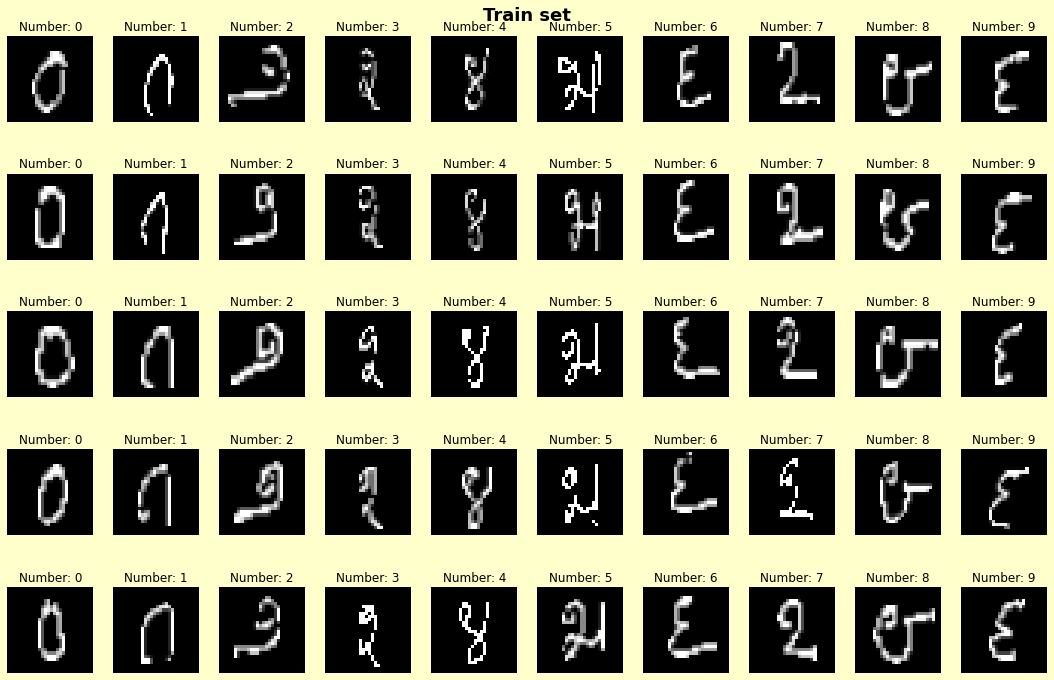

In [18]:
input_viz((x_train, y_train), 'Train set')

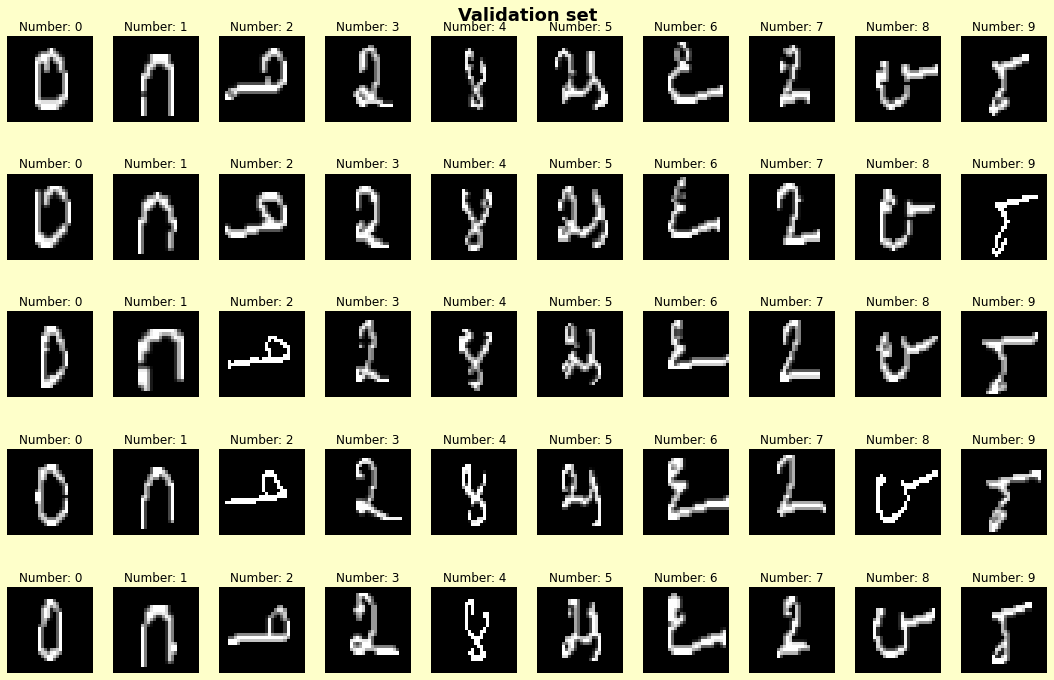

In [19]:
input_viz((x_val, y_val), 'Validation set')

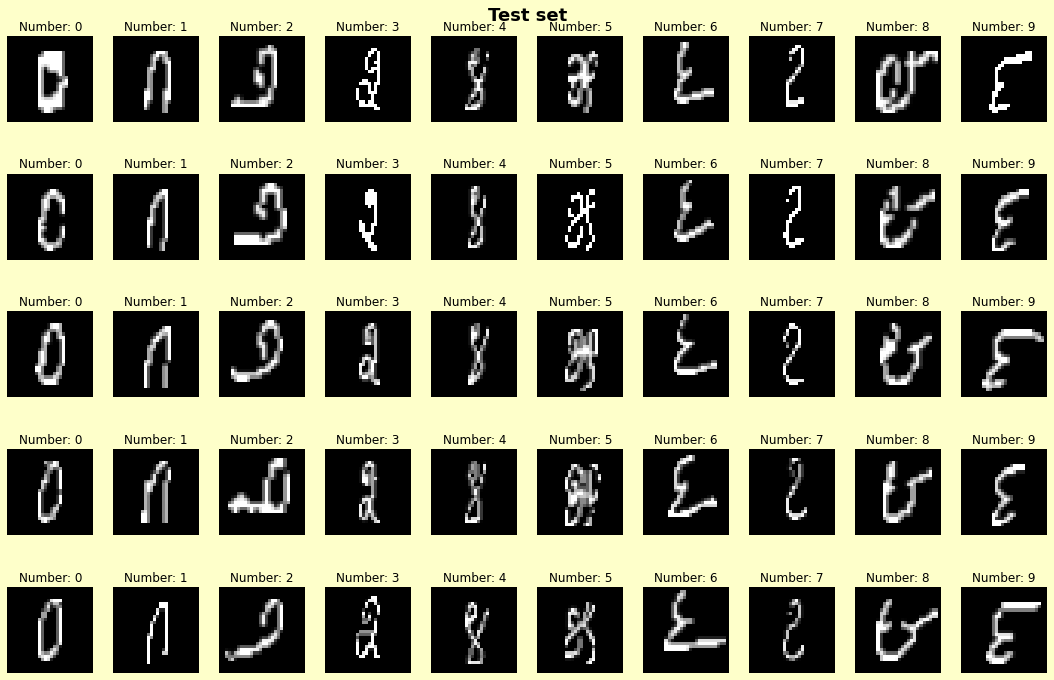

In [20]:
input_viz((x_test, y_test), 'Test set')

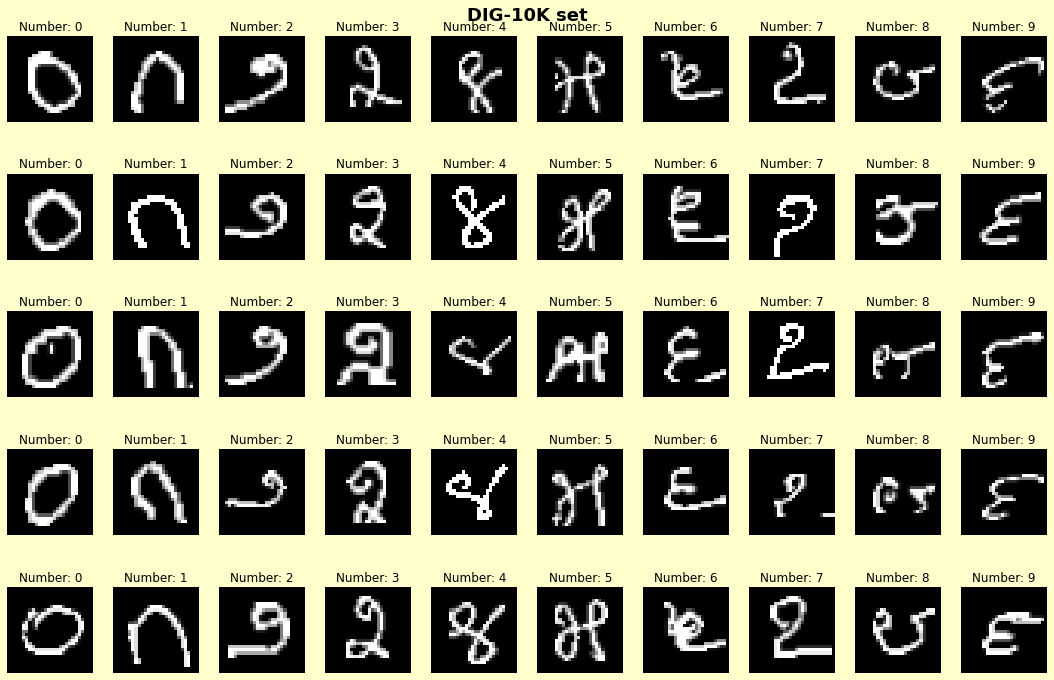

In [21]:
input_viz((x_dig, y_dig), 'DIG-10K set')

# Instantiate the model

**Define the hyperparameters**

In [22]:
class args:
  routings = 3 # number of iterations of the dynamic routing algorithm between 2 capsule layers
  digit_caps_dim_vector = 32 # number of capsules in the "digit-caps" layer OR the dimensionality of the output vectors of the digit caps layer
  batch_size = 128
  epochs = 50
  recon_loss_weight = 0.0005
  lr = 0.001

In [27]:
input_shape = x_train.shape[1:] # for kannada mnist, mnist: (28, 28, 1)
num_classes = len(np.unique(np.argmax(y_train, 1))) # for kannada mnist, mnist: 10

# define model
model = CNNet(input_shape=input_shape,
                             n_class=num_classes,
                             num_routing=args.routings,
                             digit_caps_dim_vector=args.digit_caps_dim_vector)
model.summary()

try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
outputmodel (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 28, 28, 64)        0         
__________

# Train the network

In [28]:
"""
the original research paper proposes using a SSE loss with a weight of 0.0005
that is equivalent to using the mean loss (MSE) and then multiply it by the total
values being output in the final layer
(sum = number of instances * mean)
"""
recon_lambda = args.recon_loss_weight*np.prod(input_shape)

In [32]:
from keras.preprocessing.image import ImageDataGenerator

def train(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_val, y_val) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * np.exp(-epoch / 10.))

    # compile the model
    opt = 'nadam'
    model.compile(optimizer=opt,
                  loss=margin_loss) # use MSE loss metric for the reconstruction network
                  
                  

    # Training without data augmentation:
    # history = model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
    #           validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.2):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction,  # shift up to 2 pixel for MNIST
                                           zca_whitening=True,
                                           rotation_range=20,
                                           zoom_range=0.2,
                                           shear_range=0.2)
        generator = train_datagen.flow(x, y, batch_size=args.batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, 0.2),
                        steps_per_epoch=int(y_train.shape[0]/args.batch_size),
                        epochs=args.epochs,
                        validation_data=[x_val, y_val], callbacks=[lr_decay, checkpoint, log])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [33]:
train(model=model, data=((x_train, y_train), (x_val, y_val)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
421/421 [==============================] - 26s 62ms/step - loss: 0.0638 - val_loss: 0.0054

Epoch 00001: val_loss improved from inf to 0.00537, saving model to weights-01.h5
Epoch 2/50
421/421 [==============================] - 17s 41ms/step - loss: 0.0195 - val_loss: 0.0106

Epoch 00002: val_loss did not improve from 0.00537
Epoch 3/50
421/421 [==============================] - 17s 41ms/step - loss: 0.0148 - val_loss: 0.0074

Epoch 00003: val_loss did not improve from 0.00537
Epoch 4/50
421/421 [==============================] - 17s 41ms/step - loss: 0.0119 - val_loss: 0.0034

Epoch 00004: val_loss improved from 0.00537 to 0.00339, saving model to weights-04.h5
Epoch 5/50
421/421 [==============================] - 17s 41ms/step - loss: 0.0107 - val_loss: 0.0068

Epoch 00005: val_loss did not improve from 0.00339
Epoch 6/50
421/421 [==============================] - 17s 41ms/step 

# Inference: Evaluate model performance

**Load the best weights**

**Final Weights(trained model) for this training process**

In [34]:
model.load_weights('trained_model.h5')

In [35]:
from google.colab import files
files.download("log.csv")

In [39]:
y_pred = model.predict(x_test, batch_size=args.batch_size)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

Test acc: 0.9873


In [41]:
dig_pred = model.predict(x_dig[:10000], batch_size=args.batch_size)
print('Dig acc:', np.sum(np.argmax(dig_pred, 1) == np.argmax(y_dig, 1)) / y_dig.shape[0])

Dig acc: 0.9047


**The same model trained for 50 epochs does better on both the test sets, the model probably overfit on training for than 50 epochs**

# Visualisation

**Visualise the model architecture in use**

Encoder/Capsule network

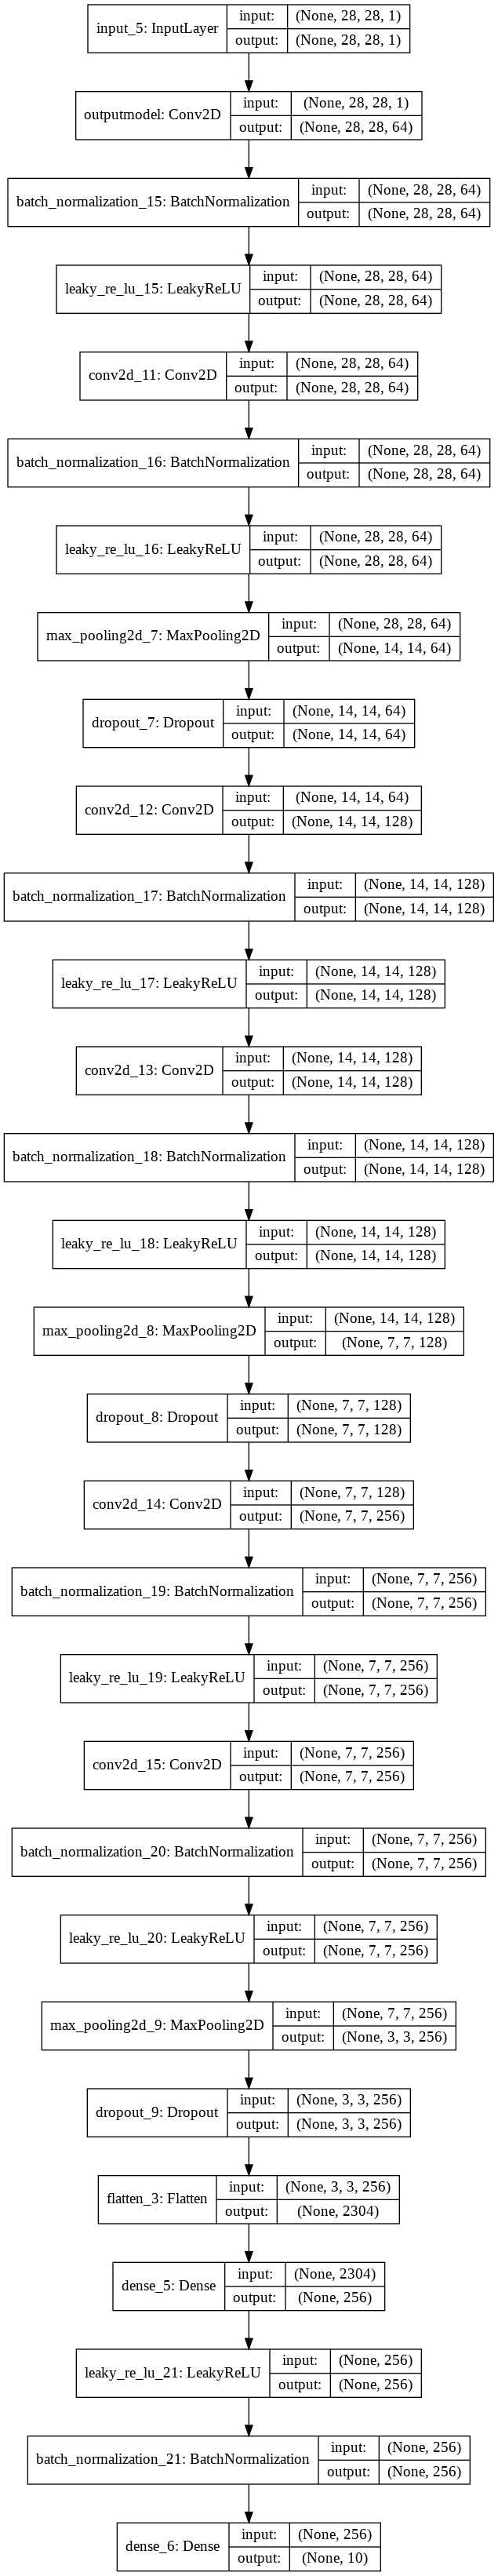

In [42]:
from IPython.display import Image
Image('model.png', width=750, height=750)

Decoder/Reconstruction network

In [ ]:
Image('decoder.png', width=450, height=750)

In [44]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('log.csv')
print(df.columns)

Index(['epoch', 'loss', 'lr', 'val_loss'], dtype='object')


**Filter the values to visualise**

In [46]:
# loss
loss = df['loss'].to_list()
val_loss = df['val_loss'].to_list()





**Configure plotting tool(here: matplotlib)**

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
plt.style.use('fivethirtyeight')
plt.rc('grid', color='k', linestyle='--')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='gray', axisbelow=True, grid=True)

**Plot the loss and accuracy values**

Text(0.5, 1.0, 'Training and Validation Loss')

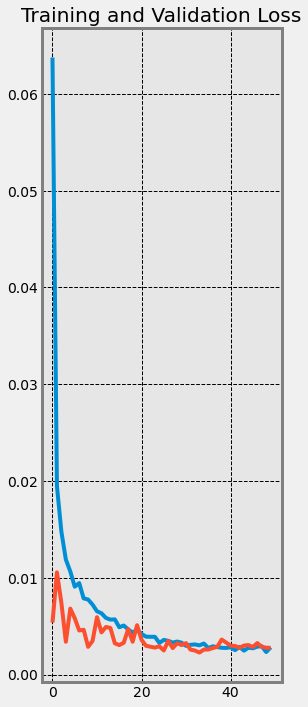

In [48]:
epochs = range(len(loss))

params = {'left' : 1,
          'right' : 3,
          'bottom' : 1,
          'top' : 3, 
          'wspace' : 1,          
          'hspace' : 0.2}
              
plt.subplots_adjust(**params)



# Plot retrieved data : loss
plt.subplot(222)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation Loss")


**Reconstruction**

Pick out 1 random image from each of test and dig sets and compare their reconstructions with the original image

**Plot the confusion matrix and calculate a digit-by-digit accuracy of the model's predictions**

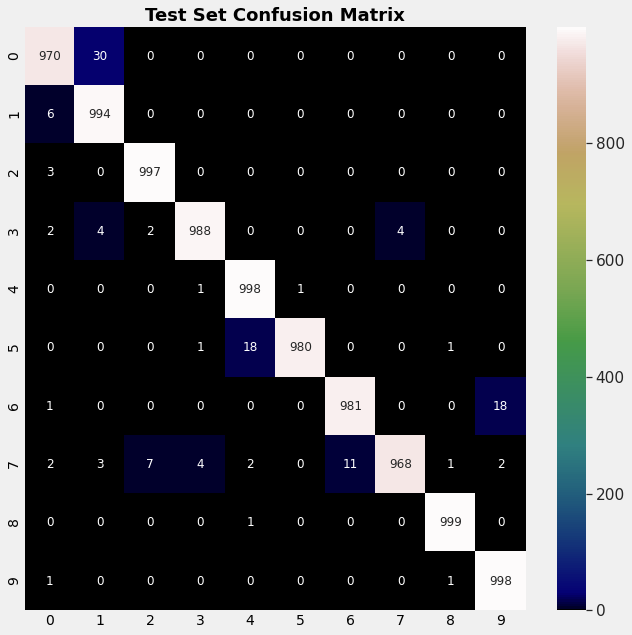

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

labels = []
preds = []
for i in range(y_test.shape[0]):
  labels.append(np.argmax(y_test[i]))
  preds.append(np.argmax(y_pred[i]))

plt.figure(figsize=(10, 10))
plt.title("Test Set Confusion Matrix", fontsize=18, fontweight="bold")
cm = confusion_matrix(labels, preds)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, fmt='g', cmap="gist_earth", annot_kws={"size": 12}) # flag_r, copper, gist_earth, icefire

plt.show()

In [50]:
print("For the Kannada MNIST test set:")
num = 0
for row in cm:
  print(f'Classification accuracy for the number {num} is {round((max(row)/sum(row)*100), 2)}%')
  num += 1

For the Kannada MNIST test set:
Classification accuracy for the number 0 is 97.0%
Classification accuracy for the number 1 is 99.4%
Classification accuracy for the number 2 is 99.7%
Classification accuracy for the number 3 is 98.8%
Classification accuracy for the number 4 is 99.8%
Classification accuracy for the number 5 is 98.0%
Classification accuracy for the number 6 is 98.1%
Classification accuracy for the number 7 is 96.8%
Classification accuracy for the number 8 is 99.9%
Classification accuracy for the number 9 is 99.8%


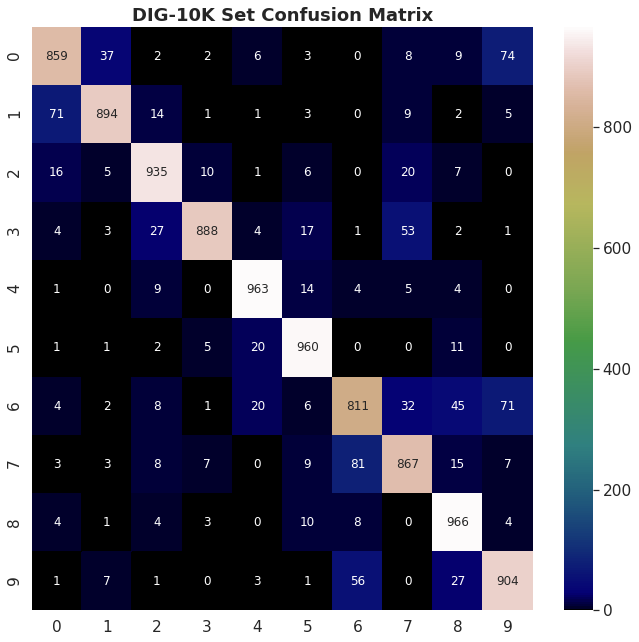

In [51]:
dig_labels = []
dig_preds = []
for i in range(y_dig.shape[0]):
  dig_labels.append(np.argmax(y_dig[i]))
  dig_preds.append(np.argmax(dig_pred[i]))

plt.figure(figsize=(10, 10))
plt.title("DIG-10K Set Confusion Matrix", fontsize=18, fontweight="bold")
dig_cm = confusion_matrix(dig_labels, dig_preds)
sn.set(font_scale=1.4) # for label size
sn.heatmap(dig_cm, annot=True, fmt='g', cmap="gist_earth", annot_kws={"size": 12}) # flag_r, copper, gist_earth, icefire

plt.show()

In [52]:
print("For the DIG-10K set:")
num = 0
for row in dig_cm:
  print(f'Classification accuracy for the number {num} is {round((max(row)/sum(row)*100), 2)}%')
  num += 1

For the DIG-10K set:
Classification accuracy for the number 0 is 85.9%
Classification accuracy for the number 1 is 89.4%
Classification accuracy for the number 2 is 93.5%
Classification accuracy for the number 3 is 88.8%
Classification accuracy for the number 4 is 96.3%
Classification accuracy for the number 5 is 96.0%
Classification accuracy for the number 6 is 81.1%
Classification accuracy for the number 7 is 86.7%
Classification accuracy for the number 8 is 96.6%
Classification accuracy for the number 9 is 90.4%
